<div style="background-color: #04da79; border: 2px solid #039754; padding: 10px; color: black; font-family: Arial, Helvetica, sans-serif;">
    <strong>Kernel: Python 3 (ipykernel)
</div>

# Lab 03: Video Analysis and Highlight Generation using Qwen2-VL
---

This notebook showcases a solution to analyze video content using the Qwen2-VL multimodal model, focusing on extracting key frames through motion detection, generating natural language descriptions of each frame, and creating a highlight reel of the most significant moments. The approach aims to automatically identify frames with notable motion or changes, describe the content in each frame, and compile these key moments into a narrative summary and highlight reel, offering both text and video formats for comprehensive content analysis.

Here are some high-level use cases that we can use a flow presented in this notebook,
- Sports Highlights Extraction
- Surveillance Video Analysis
- Content Curation for Creators
- Meeting Recap Highlights
- Educational Video Summaries
- Video Blogging (Vlogging) Highlights
- Court Evidence Summarization
- Wildlife and Nature Monitoring
- Marketing and Advertisement Clips
- Video-Based Storytelling

In [ ]:
import os
import sys
import boto3
import torch
import decord
from transformers import AutoProcessor
from vllm import LLM, SamplingParams
from qwen_vl_utils import process_vision_info
from sagemaker.model import Model

sys.path.append(os.path.dirname(os.getcwd()))
from utils.helpers import pretty_llm_print

---
Similar to `Lab 01/02 ...` We're going to load our model into GPU memory and leverage the model as Local LLM for inference. The key change here - we set the `max_model_len` to a larger value to ensure we can process larger Video chunks for a downstream use case.

---

In [ ]:
import sagemaker

session = sagemaker.Session()
default_bucket = session.default_bucket()

In [ ]:
video_llm_model_id = "Qwen/Qwen2-VL-7B-Instruct"
max_images_per_prompt = 2
max_videos_per_prompt = 2
dtype = "half"
gpu_memory_utilization = 0.95
max_model_len = 12000
enforce_eager = False

<div style="background-color: #f5aeba; border: 2px solid #610010; padding: 10px; color: black; font-family: Arial, Helvetica, sans-serif;">
    ❗❗❗ Please wait for <b>1 to 2 minutes</b> for the model to finish loading!
</div>

In [ ]:
%%time 
llm = LLM(
    model=video_llm_model_id,
    limit_mm_per_prompt={
        "image": max_images_per_prompt, 
        "video": max_videos_per_prompt
    },
    gpu_memory_utilization=gpu_memory_utilization,
    max_model_len=max_model_len,
    tensor_parallel_size=1,
    dtype=dtype,
    enforce_eager=enforce_eager
)

In [ ]:
%%time
processor = AutoProcessor.from_pretrained(
    video_llm_model_id
)

In [ ]:
%pip install "opencv-python-headless"

In [ ]:
%pip install chart-studio

---

## Video Processing Functions

In [ ]:
from typing import Dict, Tuple
import cv2
import numpy as np
from tqdm import tqdm
from scipy.signal import find_peaks
from decord import VideoReader, cpu
from IPython.display import Video
import plotly.graph_objects as go
import chart_studio.plotly as py

Let's define our core video processing functions. These will handle frame extraction and motion detection.

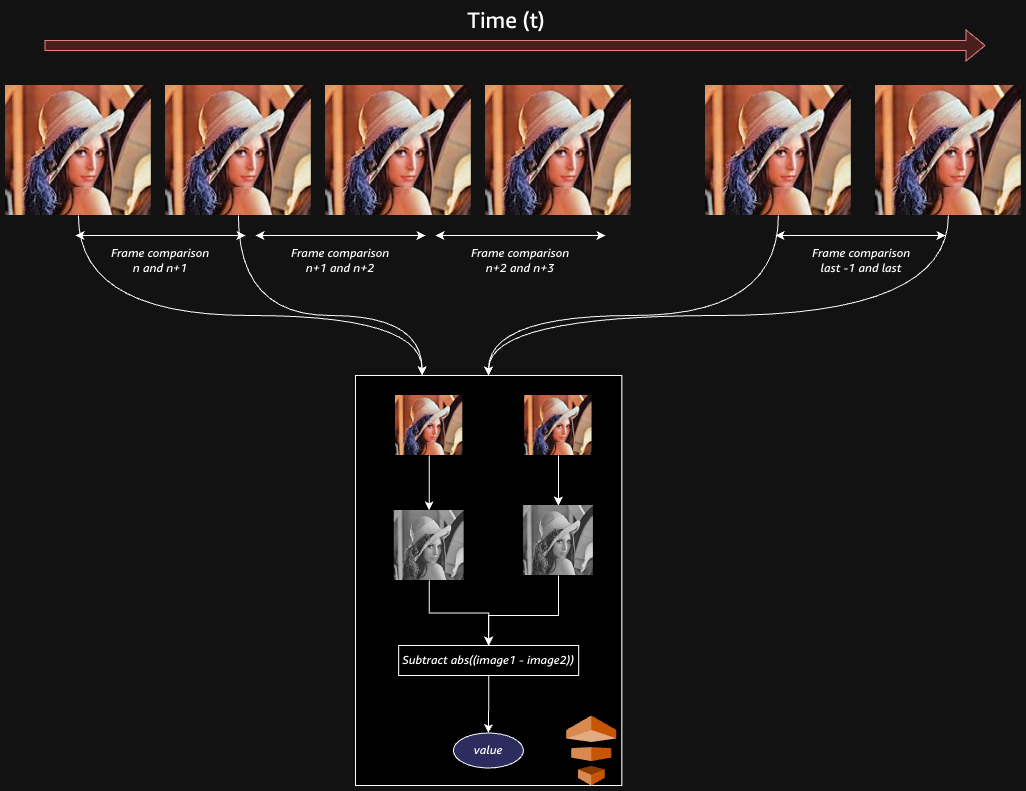

Let's understand video sampling pipeline here,
1. First we read the entire video sample into memory (the sample video here is 5 min long - so you should'nt run out of memory)
2. Next we line up all the frames of a video - A video is composed of roughly 24-30 frames per second (typically). So a 5 min video could have 5 min * 60 seconds * 30 frames per second = 9000 images to be processed by Qwen as a whole
3. Obviously, we **won't** process all the frames in a video. We **sub-sample** key frames.
Why?
It's inefficient - most frames in a "smooth" video are repeats or show very little 'events of interest'. We can safely ignore these frames in many cases without loosing much information within a video.

How do we sub-sample?
Video Key-frame detection is an area of research in the vision frame itself. In this notebook we leverage a rudimentary keyframe detection system that uses "peak-detection" technique to tell us which frames are 'key' (or drastically different from previous frames of a video so far) and use those frames to build our story.

In Summary, we use key-frame detection technique to **throw-away** redundant frames and keep only the **key-frames**.

5. We compare subsequent frames (like `n vs n+1`, `n+1 vs n+2`, etc..),

    - First, we convert the image to grayscale for efficient processing
    - Second, we blur the image to reduce sharp noise
    - Third store these in a list of values and use peak-detection technique to detect keyframes
    - Run LLM inference on sub-sampled video

Here's an example of frames selected using this method - the blue `x` marks the key frames that were selected.

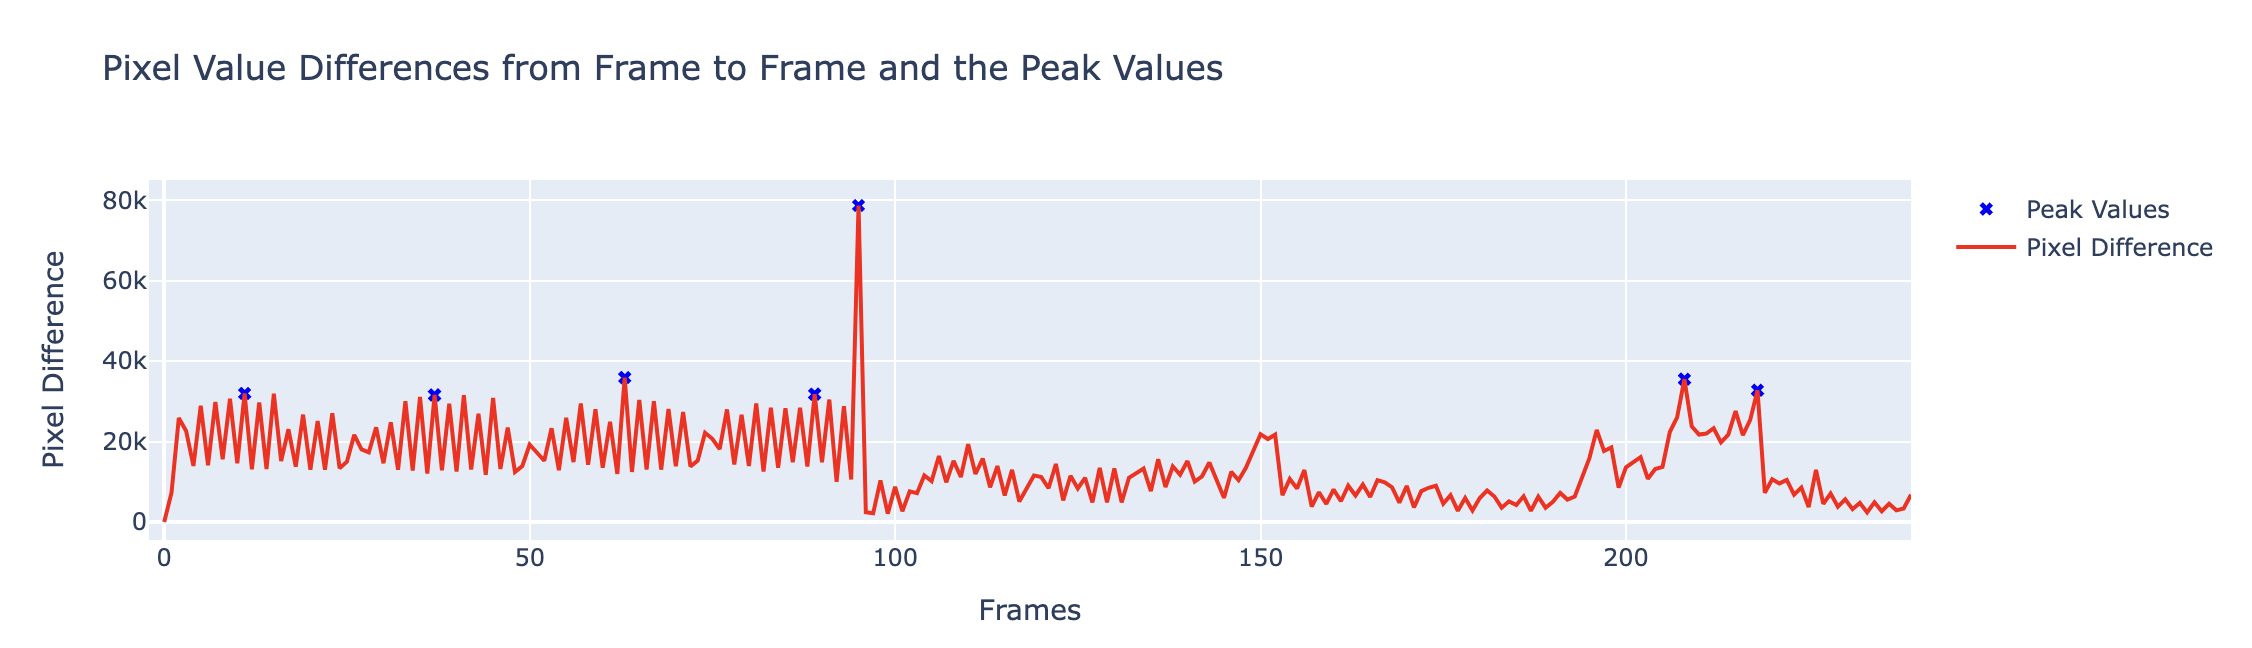

In [ ]:
def extract_keyframes(
    video_path: str, 
    video_chunk_secs: int = 10,
    motion_threshold=0.3,
    resize=(400, 300)
) -> Dict:
    """
    Read video and extract frames, determine which frames are keyframes for analysis using a peak detection technique.
    Args:
        video_path: Path to video file
        video_chunk_secs: Splits a large video into chunks of n seconds 
        motion_threshold: Minimum motion difference to consider
        resize: Frame resize value (w x h)
        
    Returns:
        Frames extracted and returned as a Dict with additional meta-data
    """
    vr = VideoReader(video_path, ctx=cpu(0))
    total_frames = len(vr)

    results = {}

    fps = vr.get_avg_fps()
    total_frames = len(vr)
    frames_per_chunk = int(video_chunk_secs * fps)

    print(f"Video has {fps} fps, {(total_frames/fps)/60} minutes with a total of {total_frames} frames\n")

    chunked_list = list(range(0, total_frames, frames_per_chunk))
    pbar = tqdm(
        chunked_list, 
        total=len(chunked_list), 
        desc="Processing Chunks"
    )
    for _start in pbar:
        st_frame, en_frame = _start, _start + frames_per_chunk
        if en_frame > total_frames:
            en_frame = total_frames

        st_time, en_time = st_frame / fps, en_frame / fps
        frames_in_chunk = vr.get_batch(range(st_frame, en_frame)).asnumpy()
        key = f"start time: {st_time:.2f} secs to end time: {en_time:.2f} secs"
        lst_diff_mag = [0]
        lstfrm = [0]
        
        for n in range(1, len(frames_in_chunk)):
            frame_this = cv2.resize(frames_in_chunk[n], resize)
            frame_last = cv2.resize(frames_in_chunk[n-1], resize)
            # conver the image to grayscale
            frame_this = cv2.cvtColor(frame_this, cv2.COLOR_RGB2GRAY)
            frame_last = cv2.cvtColor(frame_last, cv2.COLOR_RGB2GRAY)
            # blue image to reduce sharp noise
            frame_this = cv2.blur(frame_this, (9, 9))
            frame_last = cv2.blur(frame_last, (9, 9))
            # calcualate the difference between subsequent frames
            diff = cv2.subtract(frame_this, frame_last)
            # add the frame id for plotting
            lstfrm.append(n)
            diff_mag = cv2.countNonZero(diff)
            lst_diff_mag.append(diff_mag)

        y = np.array(lst_diff_mag)
        # Use scipy find_peaks instead of peakutils
        peaks, properties = find_peaks(
            y, height=motion_threshold * np.max(y), distance=5
        )
        select_frame_idx = peaks
        frames_in_chunk_s = frames_in_chunk[select_frame_idx]
        del frames_in_chunk
        c_fps = round(len(frames_in_chunk_s) / fps, 0)
        results[key] = {
            "selected_key_frames": frames_in_chunk_s,
            "lst_diff_mag": lst_diff_mag,
            "lstfrm": lstfrm,
            "select_frame_idx": select_frame_idx,
            "adjusted_fps": c_fps
        }
        # Update tqdm description with the key
        pbar.set_description(f"Processing Video: {key}")
    
    return results

Let's download our sample movie from S3: `s3://default-bucket/artifact/video/demo-big-bunny-movie.mp4`

In [ ]:
sample_video_path = session.download_data(
    path=os.path.join("sample-media"), 
    bucket=default_bucket, 
    key_prefix='artifact/video/demo-big-bunny-movie.mp4'
)

In [ ]:
sample_video_path = sample_video_path[0]
Video(sample_video_path, width=640, height=480)

<div style="background-color: #f3fd91; border: 2px solid #a2bb11; padding: 10px; color: black; font-family: Arial, Helvetica, sans-serif;">
    You can adjust the "motion_threshold" to capture <b>more</b> or <b>less</b> frames. Keep in mind, more frames requires <b>more GPU memory</b> to run inference.
</div>

In [ ]:
video_key_frames = extract_keyframes(sample_video_path, video_chunk_secs=10, motion_threshold=0.4)

In [ ]:
def plot_metrics(indices, lstfrm, lstdiffMag):
    y = np.array(lstdiffMag)

    # Create the figure
    fig = go.Figure()

    # Add the scatter plot for peak values
    fig.add_trace(go.Scatter(
        x=indices,
        y=y[indices],
        mode='markers',
        marker=dict(symbol="x", color="blue"),
        name='Peak Values'
    ))

    # Add the line plot for frame-to-frame differences
    fig.add_trace(go.Scatter(
        x=lstfrm,
        y=lstdiffMag,
        mode='lines',
        line=dict(color="red"),
        name='Pixel Difference'
    ))

    # Update layout with titles and axis labels
    fig.update_layout(
        title="Pixel Value Differences from Frame to Frame and the Peak Values",
        xaxis_title="Frames",
        yaxis_title="Pixel Difference"
    )

    return fig

In [ ]:
sample = video_key_frames[list(video_key_frames.keys())[1]]
fig = plot_metrics(
    indices=sample["select_frame_idx"], 
    lstfrm=sample["lstfrm"], 
    lstdiffMag=sample["lst_diff_mag"]
)

In [ ]:
fig.show()

---
## Run Inference on sub-sampled Video Frames and generate Transcript


In [ ]:
import io
import base64
from PIL import Image
from typing import List

Now that we have our selected frames, we're going to ask Qwen2-VL to analyze these frames and provide a verbose description. The frames are automatically select based on prior step so we're assuming that these are representative frames from a time sliced video. The prompt we choose determine the performance and the output of our model. You can choose the response format, theme, verboseness and much more by editing the prompt supplied to the model,

```json
[
        {
            "role": "system", 
            "content": "You are a helpful video assistant. You are provided with a set of frames that describe a movie." 
            "You must NOT select continuous chapters as they do not provide good story coverage."
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "video",
                    "video": ...,
                    "fps": ...
                },
                {
                    "type": "text", 
                    "text": "..."
                    )
                },
            ],
        }
    ]
```

The function `prepare_image_for_qwen` converts images as `base64` string - as Qwen understands video as,

```json

"video": [
        "frame1-image-as-base64-string",
        "frame2-image-as-base64-string",
        "frame3-image-as-base64-string",
        "frame4-image-as-base64-string",
    ]
```



In [ ]:
def prepare_image_for_qwen(chunk):
    
    video_frames = []
    for frame in chunk:
        image = Image.fromarray(frame)
        buffered = io.BytesIO()
        image.save(buffered, format="PNG")
        encoded_image = base64.b64encode(buffered.getvalue())
        encoded_image_text = encoded_image.decode("utf-8")
        base64_str = f"data:image/png;base64,{encoded_image_text}"
        video_frames.append(base64_str)
    
    return video_frames


def analyze_frames_with_qwen(
    frame_chunks: List[np.ndarray],
    llm=None,  
    processor=None
) -> List[str]:
    """
    Analyze frames using either local Qwen2-VL model or SageMaker endpoint.
    
    Args:
        frames: List of frames to analyze
        use_local_model: Whether to use local model
        local_model: The preloaded local Qwen model
        processor: The AutoProcessor corresponding to the local model
        sagemaker_endpoint: Name of SageMaker endpoint if use_local_model=False
        max_tokens: Maximum tokens for generation
        num_repeats: Number of inference repeats per frame (local model only)
        
    Returns:
        List[str]: Descriptions for each frame
    """
    
    all_descriptions = {}

    pbar = tqdm(enumerate(frame_chunks), total=len(frame_chunks), desc="Generating Summaries")
    
    for i, key in pbar:
        chunk = frame_chunks[key]
        video_frames = prepare_image_for_qwen(chunk["selected_key_frames"])
        # Prepare conversation template
        conversation = [
            {
                "role": "system", 
                "content": "You are a helpful video assistant. You are provided with a set of frames that describe a movie." 
                "You must NOT select continuous chapters as they do not provide good story coverage."
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "video",
                        "video": video_frames,
                        "fps": float(chunk["adjusted_fps"]) + 1,
                    },
                    {
                        "type": "text", 
                        "text": (
                            "Describe the story in this video in great detail. Keep the following aspects in mind when describing this video,"
                            "1. This video is a part of a movie. Ensure you capture the story presented in this video"
                            "2. Describe the video as if you were telling the user a story"
                            "3. Be sure to capture any interesting aspects of the video (ex: character jumping, falling, etc..)"
                            "4. Be sure to tell the story behind the video"
                        )
                    },
                ],
            }
        ]

        prompt = processor.apply_chat_template(
            conversation,
            tokenize=False,
            add_generation_prompt=True,
        )
        image_inputs, video_inputs = process_vision_info(conversation)
        mm_data = {}
        if image_inputs is not None:
            mm_data["image"] = image_inputs
        if video_inputs is not None:
            mm_data["video"] = video_inputs
        
        llm_inputs = {
            "prompt": prompt,
            "multi_modal_data": mm_data,
        }
        outputs = llm.generate(
            [llm_inputs], 
            sampling_params=SamplingParams(
                temperature=0.9,
                top_p=0.001,
                repetition_penalty=1.05,
                max_tokens=2048,
                stop_token_ids=[]
            )
        )
        
        pbar.set_description(f"Processing Video: {key}")
        
        all_descriptions[key] = f"Chapter {i+1}\n**Story**: {outputs[0].outputs[0].text}" 

        # Update tqdm description with the key
        pbar.set_description(f"Processing Video: {key}")
            
    return all_descriptions

In [ ]:
descriptions = analyze_frames_with_qwen(video_key_frames, llm=llm, processor=processor)

In [ ]:
_sk = list(descriptions.keys())[0]
_transcript = descriptions[list(descriptions.keys())[0]]
print(f"*********\n{_sk}:\n*********\n\n{_transcript}")

## Asking Vid-LLM (`Qwen2-VL`) to Select the most Important Cut Scenes

Now that we have our video extracted as a transcript, `descriptions` should be the format as below,

```json
{
    ...
    'start time: 220.00 secs to end time: 230.00 secs': "...nature and animals.",
    'start time: 230.00 secs to end time: 240.00 secs': "...rabbit's reaction all the more striking.",
    'start time: 240.00 secs to end time: 250.00 secs': "... every movement it makes.",
    ...
}
```

In [ ]:
content = []

# Add video chunk by chunk description
for k in descriptions:
    content.append(
        {
            "type": "text",
            "text": f"Story {descriptions[k]}"
        }
    )

# final agenda prompt - this tells the model what it needs to do
content.append(
    {
        "type": "text",
        "text": (
            "Select 7-10 best chapters from this story." 
            "Select atleast 1 chapter every 5 chapters. Provide a reason for your selection." 
            "Ensure you select one closing chapter too."
        )
    })

In [ ]:
messages = [
    {
        "role": "system",
        "content": "You are a helpful AI assistant. You answer all users questions and follow all requests."
    },
    {
        "role": "user",
        "content": content
    }
]


In [ ]:
prompt = processor.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
image_inputs, video_inputs = process_vision_info(messages)
mm_data = {}
if image_inputs is not None:
    mm_data["image"] = image_inputs
if video_inputs is not None:
    mm_data["video"] = video_inputs

llm_inputs = {
    "prompt": prompt,
    "multi_modal_data": mm_data,
}

In [ ]:
outputs = llm.generate(
    [llm_inputs], 
    sampling_params=SamplingParams(
        temperature=0.1,
        top_p=0.01,
        repetition_penalty=1.05,
        max_tokens=10000,
        stop_token_ids=[],
    )
)
generated_text = outputs[0].outputs[0].text
messages.append({"role": "assistant", "content": generated_text})

In [ ]:
pretty_llm_print(messages, title=video_llm_model_id)

---
## Generate Highlight Reel

In [ ]:
import re
import imageio.v3 as imageio
from PIL import Image
import numpy as np
from typing import List

Last Stage,

1. We have - the entire video extracted video as a transcript - between time slice start to time slice end
2. Next, we extract the video sections that seem interesting according to a `Vid-LLM`
3. Automatically Stich these clips - which are essentially highlights of a long form video which are a fraction of the time

In [ ]:
def extract_chapter_ids(text_blob):
    """
    Extracts Chapter IDs from a given text blob.

    Args:
        text_blob (str): The input text blob containing chapter information.

    Returns:
        list: A list of chapter IDs as integers.
    """
    chapter_ids = re.findall(r"Chapter (\d+)", text_blob)
    return [f"Chapter {c}\n" for c in list(map(int, chapter_ids))]

In [ ]:
select_chapters = extract_chapter_ids(generated_text)
print(f"Selected the following chapters =====>\n\n- {'- '.join(select_chapters)}")

In [ ]:
select_frame_keys = []
for k in descriptions:
    chapter_desc = descriptions[k]
    for c_id in select_chapters:
        if c_id in chapter_desc:
            select_frame_keys.append(k)

highlight_reel = []

for k in select_frame_keys:
    highlight_reel.extend(list(video_key_frames[k]['selected_key_frames']))

In [ ]:
def create_video_from_frames(frames: List[np.array], output_path: str, hold_time: float = 0.2):
    """
    Create a smooth video from a list of frames with each frame held for a specified time.

    Args:
        frames (List[np.array]): List of frames as numpy arrays.
        output_path (str): Path to save the output smooth video.
        hold_time (float): Time (in seconds) to hold each frame. Defaults to 0.2 seconds.
    """
    if hold_time <= 0:
        raise ValueError("Hold time must be a positive value.")
    
    # Calculate frames per second based on hold time
    fps = int(1 / hold_time)
    
    # Ensure all frames have the same shape
    frame_shape = frames[0].shape
    if not all(frame.shape == frame_shape for frame in frames):
        raise ValueError("All frames must have the same shape.")
    
    # Save the video using imageio
    imageio.imwrite(
        output_path,
        frames,
        fps=fps,
        codec="libx264"
    )
    print(f"Smooth video saved at: {output_path}")

If you want a smoother video increase the `hold_time` otherwise short fast highlight clip, reduce the `hold_time`

In [ ]:
save_video_path = "./highlight.mp4"
create_video_from_frames(
    frames=highlight_reel, 
    output_path=save_video_path,
    hold_time=0.4
)

In [ ]:
Video(save_video_path, width=640, height=480)

In [ ]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(restart=True)